
📊 Avaliando previsão para t+1 (look_back LSTM=5)...
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   Descobrindo parâmetros dos modelos RF:
   Debug D3: Modelo espera 24 features, usando look_back=24
   Debug D2: Modelo espera 24 features, usando look_back=24
   Debug D1: Modelo espera 24 features, usando look_back=24
✅ t+1: RMSE=3.1510 | MAE=2.5116 | MAPE=26.12% | C30=63.48%


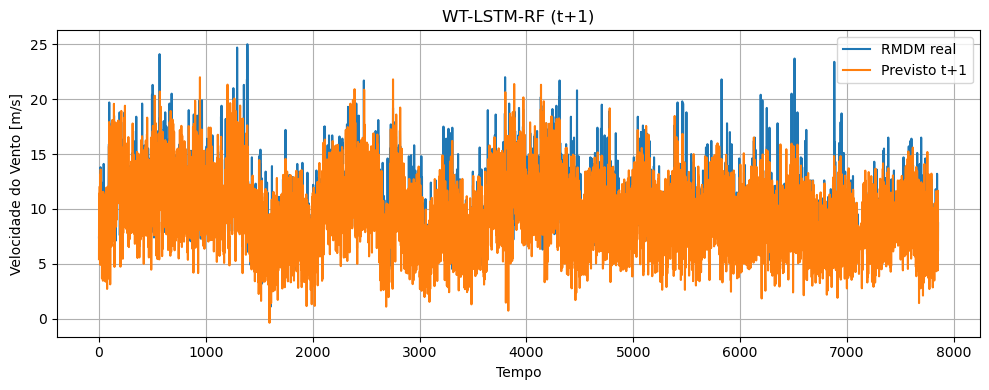


📊 Avaliando previsão para t+5 (look_back LSTM=5)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   Descobrindo parâmetros dos modelos RF:
   Debug D3: Modelo espera 5 features, usando look_back=5
   Debug D2: Modelo espera 5 features, usando look_back=5
   Debug D1: Modelo espera 5 features, usando look_back=5
✅ t+5: RMSE=1.5938 | MAE=1.2029 | MAPE=12.47% | C30=93.66%


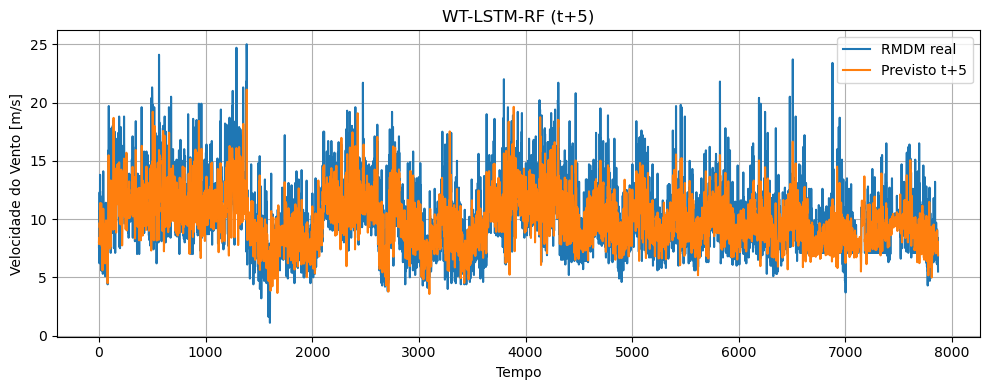


📊 Avaliando previsão para t+7 (look_back LSTM=10)...
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
   Descobrindo parâmetros dos modelos RF:
   Debug D3: Modelo espera 24 features, usando look_back=24
   Debug D2: Modelo espera 24 features, usando look_back=24
   Debug D1: Modelo espera 24 features, usando look_back=24
✅ t+7: RMSE=3.2953 | MAE=2.6888 | MAPE=30.34% | C30=59.86%


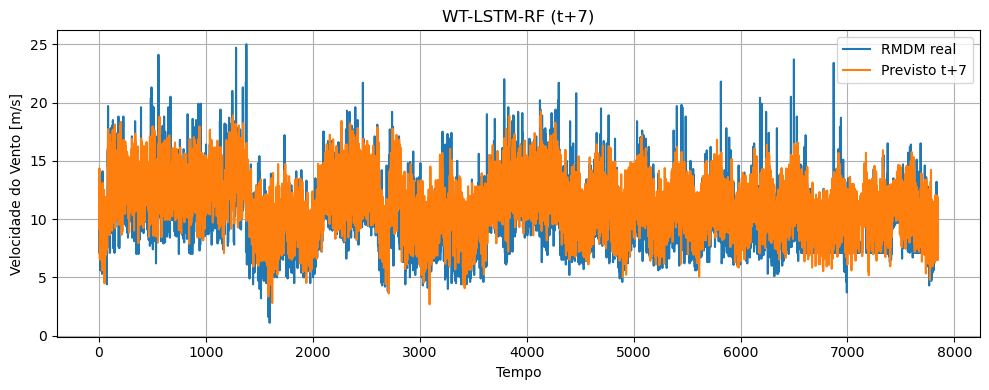


📊 Avaliando previsão para t+30 (look_back LSTM=10)...
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
   Descobrindo parâmetros dos modelos RF:
   Debug D3: Modelo espera 10 features, usando look_back=10
   Debug D2: Modelo espera 10 features, usando look_back=10
   Debug D1: Modelo espera 10 features, usando look_back=10
✅ t+30: RMSE=2.5921 | MAE=2.1501 | MAPE=25.03% | C30=67.73%


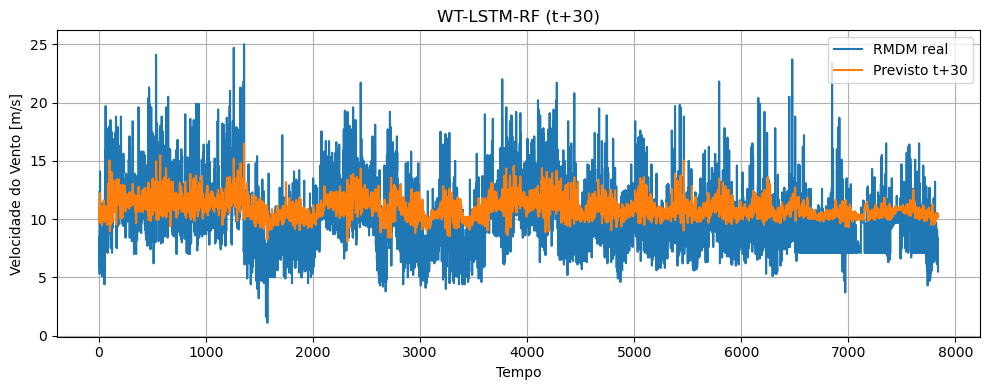


📊 Tabela final de métricas:
       RMSE    MAE    MAPE     C30
t+1   3.151  2.512  26.120  63.484
t+5   1.594  1.203  12.475  93.659
t+7   3.295  2.689  30.339  59.862
t+30  2.592  2.150  25.027  67.725


In [9]:
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def criar_dataset_multi_step(series, look_back=10, passo=1):
    X, y = [], []
    for i in range(len(series) - look_back - passo + 1):
        X.append(series[i:i + look_back])
        y.append(series[i + look_back + passo - 1])
    return np.array(X), np.array(y)

def calcular_metricas(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100
    c30 = np.sum((y_pred >= 0.7 * y_true) & (y_pred <= 1.3 * y_true)) / len(y_true) * 100
    return rmse, mae, mape, c30

def descobrir_look_back_do_modelo(nome_comp, passo):
    """Descobre qual look_back foi usado no treinamento"""
    try:
        modelo = joblib.load(f"modelosRF/rf_{nome_comp.lower()}_t{passo}.joblib")
        n_features_esperadas = modelo.n_features_in_
        
        # Se o modelo foi treinado sem features engineered, n_features = look_back
        look_back_usado = n_features_esperadas
        
        print(f"   Debug {nome_comp.upper()}: Modelo espera {n_features_esperadas} features, usando look_back={look_back_usado}")
        return look_back_usado
        
    except Exception as e:
        print(f"   Erro ao descobrir look_back para {nome_comp}: {e}")
        return 5

def prever_componente_rf(nome_comp, passo, look_back_lstm):
    # Descobrir o look_back correto usado no treinamento do RF
    look_back_rf = descobrir_look_back_do_modelo(nome_comp, passo)
    
    serie = pd.read_csv(f"{nome_comp.upper()}_component.csv")[nome_comp.upper()].values.reshape(-1, 1)
    scaler = joblib.load(f"scalersRF/scaler_{nome_comp.lower()}_t{passo}.joblib")
    serie_scaled = scaler.transform(serie)
    
    # Usar a função básica (sem features engineered, igual ao SVR original)
    X, _ = criar_dataset_multi_step(serie_scaled, look_back_rf, passo)
    X = X.reshape((X.shape[0], X.shape[1]))  # FLATTEN para 2D igual ao SVR
    
    modelo = joblib.load(f"modelosRF/rf_{nome_comp.lower()}_t{passo}.joblib")
    y_pred_scaled = modelo.predict(X)
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    return y_pred

def recompor_e_avaliar(passo):
    look_back = 5 if passo <= 5 else 10
    print(f"\n📊 Avaliando previsão para t+{passo} (look_back LSTM={look_back})...")

    df = pd.read_csv("RMDM_corrigido.csv")
    rmdm_real = df["RMDM"].values

    df_a3 = pd.read_csv("A3_component.csv")
    a3 = df_a3["A3"].values

    scaler_a3 = joblib.load(f"scaler_A3_t{passo}.joblib")
    a3_scaled = scaler_a3.transform(a3.reshape(-1, 1))
    X_a3, _ = criar_dataset_multi_step(a3_scaled, look_back, passo)
    X_a3 = X_a3.reshape((X_a3.shape[0], X_a3.shape[1], 1))

    model_a3 = load_model(f"lstm_a3_t{passo}.keras")
    y_pred_a3_scaled = model_a3.predict(X_a3).flatten()
    y_pred_a3 = scaler_a3.inverse_transform(y_pred_a3_scaled.reshape(-1, 1)).flatten()

    print("   Descobrindo parâmetros dos modelos RF:")
    y_pred_d3 = prever_componente_rf("d3", passo, look_back)
    y_pred_d2 = prever_componente_rf("d2", passo, look_back)
    y_pred_d1 = prever_componente_rf("d1", passo, look_back)

    limite = 3.0
    y_pred_d1 = np.clip(y_pred_d1, -limite, limite)
    y_pred_d2 = np.clip(y_pred_d2, -limite, limite)
    y_pred_d3 = np.clip(y_pred_d3, -limite, limite)

    min_len = min(len(y_pred_a3), len(y_pred_d1), len(y_pred_d2), len(y_pred_d3))
    y_final = (
        y_pred_a3[:min_len] +
        y_pred_d3[:min_len] +
        y_pred_d2[:min_len] +
        y_pred_d1[:min_len]
    )

    y_real = rmdm_real[look_back + passo - 1:look_back + passo - 1 + min_len]

    rmse, mae, mape, c30 = calcular_metricas(y_real, y_final)
    print(f"✅ t+{passo}: RMSE={rmse:.4f} | MAE={mae:.4f} | MAPE={mape:.2f}% | C30={c30:.2f}%")

    plt.figure(figsize=(10, 4))
    plt.plot(y_real, label="RMDM real")
    plt.plot(y_final, label=f"Previsto t+{passo}")
    plt.title(f"WT-LSTM-RF (t+{passo})")
    plt.xlabel("Tempo")
    plt.ylabel("Velocidade do Vento [m/s]")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {f"t+{passo}": {"RMSE": rmse, "MAE": mae, "MAPE": mape, "C30": c30}}

# Executar
resultados = {}
for passo in [1, 5, 7, 30]:
    res = recompor_e_avaliar(passo)
    resultados.update(res)

print("\n📊 Tabela final de métricas:")
print(pd.DataFrame(resultados).T.round(3))